### Lecture 2

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

False

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')


device

device(type='cpu')

In [4]:
#dimension of the noise given to the gan
noise_dim = 100

#number of the labels in the dataset 
label_dim = 10

#### Generator Model

In [5]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        #Defining the sequential of the network
        self.fcn = torch.nn.Sequential(
            # Fully Connected Layer 1
            # Here the size of the input is the noise plus the label dimension (hot encoded)
            torch.nn.Linear(
                in_features=noise_dim + label_dim,
                out_features=240,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # Fully Connected Layer 2
            torch.nn.Linear(
                in_features=240,
                out_features=240,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # Fully Connected Layer 3
            torch.nn.Linear(
                in_features=240,
                out_features=240,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # Fully Connected Layer 4
            torch.nn.Linear(
                in_features=240,
                out_features=240,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # Fully Connected Layer 5
            torch.nn.Linear(
                in_features=240,
                out_features=240,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # Fully Connected Layer 6
            torch.nn.Linear(
                in_features=240,
                out_features=784,
                bias=True
            ),
            torch.nn.Sigmoid()
        )
    
    # label is the condition
    def forward(self, batch, labels):
        inputs = batch.view(batch.size(0), -1)
        # concatenate noise and labels
        ret = torch.cat((inputs, labels), dim=1)
        ret = self.fcn(ret)
        return ret

#### Maxout Activation

##### Source: https://github.com/pytorch/pytorch/issues/805

In [6]:
class Maxout(torch.nn.Module):

    def __init__(self, num_pieces):

        super(Maxout, self).__init__()

        self.num_pieces = num_pieces

    def forward(self, x):

        # x.shape = (batch_size? x 625)

        assert x.shape[1] % self.num_pieces == 0  # 625 % 5 = 0

        ret = x.view(
            *x.shape[:1],  # batch_size
            x.shape[1] // self.num_pieces,  # piece-wise linear
            self.num_pieces,  # num_pieces
            *x.shape[2:]  # remaining dimensions if any
        )
        
        # ret.shape = (batch_size? x 125 x 5)

        # https://pytorch.org/docs/stable/torch.html#torch.max        
        ret, _ = ret.max(dim=2)

        # ret.shape = (batch_size? x 125)

        return ret

#### Discriminator Model

In [7]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.fcn = torch.nn.Sequential(
            # Fully Connected Layer 1
            # The input is the image plus the label as a condition
            torch.nn.Linear(
                in_features=784 + label_dim,
                out_features=240,
                bias=True
            ),
            Maxout(5),
            torch.nn.Dropout(0.5),
            # Fully Connected Layer 2
            torch.nn.Linear(
                in_features=48,
                out_features=240,
                bias=True
            ),
            Maxout(5),
            torch.nn.Dropout(0.5),
            # Fully Connected Layer 3
            torch.nn.Linear(
                in_features=48,
                out_features=240,
                bias=True
            ),
            Maxout(5),
            torch.nn.Dropout(0.5),
            # Fully Connected Layer 4
            torch.nn.Linear(
                in_features=48,
                out_features=1,
                bias=True
            ),
            torch.nn.Sigmoid() #0-fake 1-real
        )

    def forward(self, batch, labels):
        ret = batch.view(batch.size(0), -1)
        #concat the image with the label
        ret = torch.cat((ret, labels), dim=1)
        ret = self.fcn(ret)
        return ret

#### MNIST Dataset

In [8]:
import torchvision

In [9]:
class FlattenTransform:
    
    def __call__(self, inputs):
        return inputs.view(inputs.shape[0], -1)
        

data_train = torchvision.datasets.MNIST(
    './data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        FlattenTransform()
    ])
)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...


/home/stephany/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729004493/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [10]:
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

#### Optimizer

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


discriminator_optimizer = torch.optim.SGD(
    discriminator.parameters(),
    lr=0.001,
    momentum=0.5,
#     dampening=0.0001
)

generator_optimizer = torch.optim.SGD(
    generator.parameters(),
    lr=0.001,
    momentum=0.5,
#     dampening=0.0001
)

criterion = torch.nn.BCELoss()

#### Optimizer Scheduler

In [12]:
'''
discriminator_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=discriminator_optimizer,
    step_size=1,
    gamma=0.99,
    last_epoch=-1
)

generator_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=generator_optimizer,
    step_size=1,
    gamma=0.99,
    last_epoch=-1
)
'''

'\ndiscriminator_scheduler = torch.optim.lr_scheduler.StepLR(\n    optimizer=discriminator_optimizer,\n    step_size=1,\n    gamma=0.99,\n    last_epoch=-1\n)\n\ngenerator_scheduler = torch.optim.lr_scheduler.StepLR(\n    optimizer=generator_optimizer,\n    step_size=1,\n    gamma=0.99,\n    last_epoch=-1\n)\n'

#### Lambda Learning Rate

In [13]:
'''
class DecayLR:
    
    def __init__(self, _lr, _step_size):
        
        self.lr = _lr
        self.step_size = _step_size
    
    def __call__(self, _epoch):

        if _epoch % self.step_size == 0:
            self.lr = self.lr * 0.1
        
        return self.lr


discriminator_scheduler = torch.optim.lr_scheduler.LambdaLR(
    discriminator_optimizer,
    DecayLR(
        _lr=0.9,
        _step_size=100
    )
)

generator_scheduler = torch.optim.lr_scheduler.LambdaLR(
    generator_optimizer,
    DecayLR(
        _lr=0.9,
        _step_size=100
    )
)
'''

'\nclass DecayLR:\n    \n    def __init__(self, _lr, _step_size):\n        \n        self.lr = _lr\n        self.step_size = _step_size\n    \n    def __call__(self, _epoch):\n\n        if _epoch % self.step_size == 0:\n            self.lr = self.lr * 0.1\n        \n        return self.lr\n\n\ndiscriminator_scheduler = torch.optim.lr_scheduler.LambdaLR(\n    discriminator_optimizer,\n    DecayLR(\n        _lr=0.9,\n        _step_size=100\n    )\n)\n\ngenerator_scheduler = torch.optim.lr_scheduler.LambdaLR(\n    generator_optimizer,\n    DecayLR(\n        _lr=0.9,\n        _step_size=100\n    )\n)\n'

#### Visualize Function

In [14]:
# visualisation is important since there's no objective way to evaluate the output of the gans

def visualizeGAN(tgt_pth, images, labels, epoch):

    fig, axes = plt.subplots(2, 5, figsize=(20, 18))
    
    fig.suptitle('Epoch {}'.format(str(epoch).zfill(4)))

    for row, axe in enumerate(axes):
        for col, cell in enumerate(axe):
            cell.imshow(
                images[row * 5 + col],
                cmap='gray'
            )
            
            cell.set_title('{}'.format(
                torch.argmax(labels[row * 5 + col])
            ))

            cell.axis("off")


    plt.axis("off")
    plt.tight_layout()

    fig.savefig(os.path.join(tgt_pth, '{}.jpg'.format(str(epoch).zfill(3))))
    
    plt.close()

#### Onehot Encoding

In [15]:
# To preprocess the data or the target labels
def encodeOneHot(labels):
    ret = torch.FloatTensor(labels.shape[0], label_dim) #Batch size
    ret.zero_()
    ret.scatter_(dim=1, index=labels.view(-1, 1), value=1)
    return ret

#### Train GANs

In [16]:
real_labels = torch.ones(BATCH_SIZE, 1).to(device)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

#noise given to the generator, we can control the distribution given to the generator
test_z = (2 * torch.randn(10, noise_dim) - 1).to(device) # number between [-1 1] mean zero, std = 1
test_y = encodeOneHot(torch.tensor(np.arange(0, 10))).to(device) # conditions (from 0 to 9)

num_epochs = 256
num_steps = len(train_loader) // BATCH_SIZE

In [17]:
import os

visuals_dir = 'visuals-section-3-lecture-2-c'

if not os.path.exists(visuals_dir):
    os.mkdir(visuals_dir)

In [18]:
#logging the loss and the learning rate
d_loss_ls = []
g_loss_ls = []
d_lr_ls = []
g_lr_ls = []


for epoch in range(num_epochs):
    
    # Loss Log
    d_counter = 0
    g_counter = 0
    d_loss = 0
    g_loss = 0

    for i, (images, labels) in enumerate(train_loader):

        if i == num_steps:
            break

        # Train Discriminator 4 steps more than generator
        for _ in range(4):
        
            real_images = images.to(device)
            real_conditions = encodeOneHot(labels).to(device)
            
            fake_conditions = encodeOneHot(
                torch.randint(0, 10, (BATCH_SIZE,))
            ).to(device)

            fake_images = generator(
                (2 * torch.randn(BATCH_SIZE, noise_dim) - 1)
                .to(device),
                fake_conditions
            )
            
            # Reseting the gradients
            discriminator_optimizer.zero_grad()
            
            real_outputs = discriminator(
                real_images, real_conditions)
            fake_outputs = discriminator(
                fake_images, fake_conditions)
            
            # Pass the real and fake images plus conditions
            d_x = criterion(real_outputs, real_labels)
            d_g_z = criterion(fake_outputs, fake_labels)
            
            # Calculate the gradients
            d_x.backward()
            d_g_z.backward()
            
            # Update the weights
            discriminator_optimizer.step()
            
            # Loss Log
            d_counter += 1
            d_loss = d_x.item() + d_g_z.item()


        # Train Generator
        # generate the noise and the fake label 
        z = (2 * torch.randn(BATCH_SIZE, noise_dim) - 1).to(device)
        y = encodeOneHot(torch.randint(0, 10, (BATCH_SIZE,))).to(device)

        generator.zero_grad()

        outputs = discriminator(generator(z, y), y)        
        
        loss = criterion(outputs, real_labels) # Flip the labels for the generator
        # maximizing the probability that the generator will generate images that 
        # don't get recognized by the discriminator as fake 

        loss.backward()

        generator_optimizer.step()
        
        # LR Decay
#         discriminator_scheduler.step()
#         generator_scheduler.step()
        
        # Loss Log
        g_counter += 1
        g_loss += loss.item()

    # Loss Log
    if epoch % 10 == 0:
        print(
            'e:{}, G:{:.3f}, D:{:.3f}'.format(
                epoch,
                g_loss / g_counter,
                d_loss / d_counter
#                 generator_scheduler.get_lr(),
#                 discriminator_scheduler.get_lr()
            )
        )
    
    # Loss Log for Plot
    g_loss_ls.append(g_loss / g_counter)
    d_loss_ls.append(d_loss / d_counter)
    
    # Learning Rate Decay Log
#     g_lr_ls.append(generator_scheduler.get_lr())
#     d_lr_ls.append(discriminator_scheduler.get_lr())


    # Visualize Results
    if epoch % 5 == 0:

        generated = generator(test_z, test_y).detach().cpu().view(-1, 28, 28)

        visualizeGAN(visuals_dir, generated, test_y, epoch)

e:0, G:0.690, D:0.024
e:10, G:2.673, D:0.013
e:20, G:4.913, D:0.008
e:30, G:6.884, D:0.005
e:40, G:8.910, D:0.003
e:50, G:10.865, D:0.002
e:60, G:12.429, D:0.002
e:70, G:5.898, D:0.005
e:80, G:1.978, D:0.013
e:90, G:1.489, D:0.015
e:100, G:3.003, D:0.007
e:110, G:2.682, D:0.007
e:120, G:3.770, D:0.005
e:130, G:4.549, D:0.003
e:140, G:4.715, D:0.003
e:150, G:3.990, D:0.005
e:160, G:4.142, D:0.008
e:170, G:4.701, D:0.003
e:180, G:4.737, D:0.003
e:190, G:4.742, D:0.004
e:200, G:4.470, D:0.003
e:210, G:4.674, D:0.005
e:220, G:4.372, D:0.006
e:230, G:4.529, D:0.005
e:240, G:4.752, D:0.008
e:250, G:5.412, D:0.003


In [20]:
# Visualize Results
generated = generator(test_z, test_y).detach().cpu().view(-1, 28, 28)

visualizeGAN(visuals_dir, generated, test_y, epoch)

#### Visualize Loss

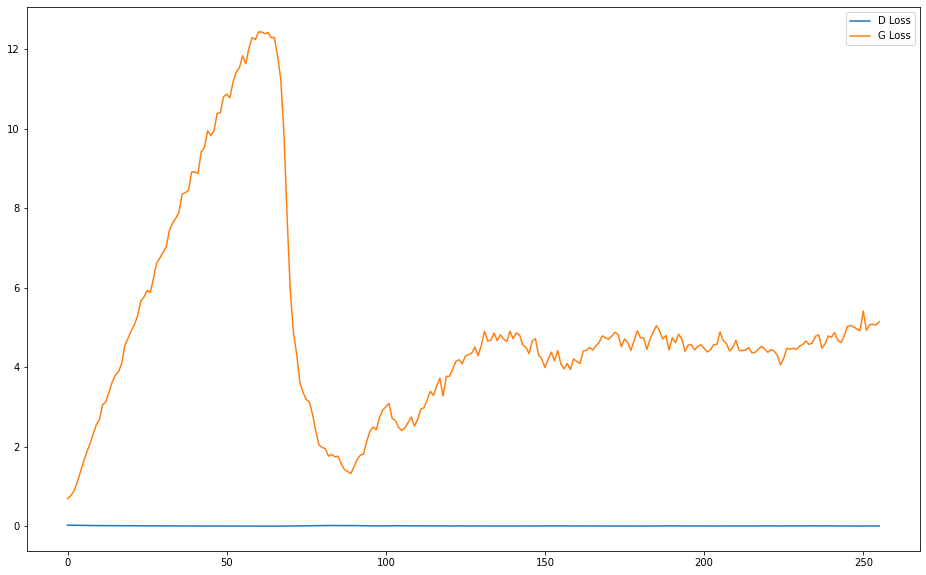

In [21]:
# loss function
fig = plt.figure(figsize=(16, 10))
plt.plot(d_loss_ls, label='D Loss')
plt.plot(g_loss_ls, label='G Loss')
plt.legend()
plt.show();

# discriminator loss is almost zero for most of the time (outperform the generator)
# the loss in the generator increase as the discriminator learns how to identify fake images
# then the generator gets stronger (learning useful information and finetune outputs) and the loss starts decreasing 

#### Visualize Learning Rate Decay

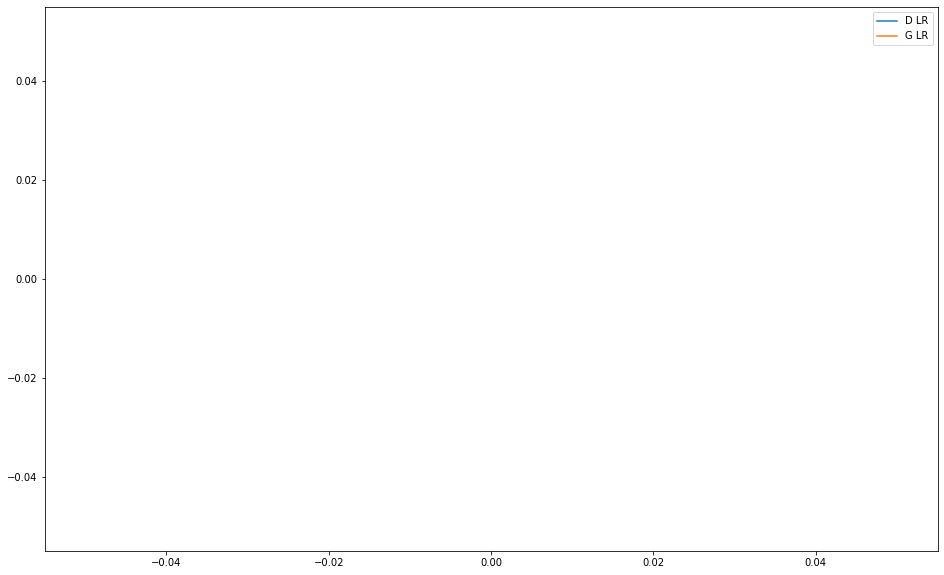

In [23]:
fig = plt.figure(figsize=(16, 10))
plt.plot(d_lr_ls, label='D LR')
plt.plot(g_lr_ls, label='G LR')
plt.legend()
plt.show();

#### Visualize Outputs

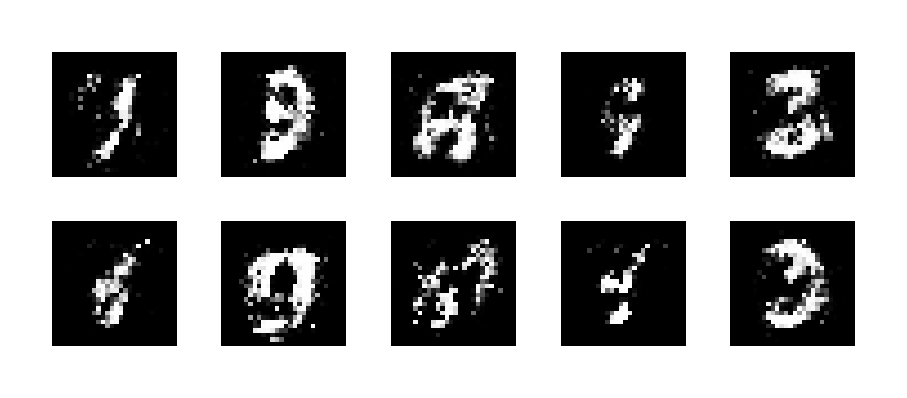

In [24]:
# Visualize Results
test_z = (2 * torch.randn(10, noise_dim) - 1).to(device)

generated = generator(test_z, test_y).detach().cpu().view(-1, 1, 28, 28)

grid = torchvision.utils.make_grid(
    generated,
    nrow=5,
    padding=10,
    pad_value=1
)

img = np.transpose(
    grid.numpy(),
    (1, 2, 0)
)

fig = plt.figure(figsize=(16, 16))
plt.axis("off")
plt.imshow(img);

#### Google Collaboratory

Notebook: https://colab.research.google.com/drive/1O0Id95mJUZLsxu3AJy8xCNMm5phbeYh7